# importing librairies


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import warnings
import itertools
import sklearn
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import pytz
from statsmodels.tsa.stattools import adfuller
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA


# data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 =pd.read_csv("/content/drive/MyDrive/MY PAPERS/2004.csv", error_bad_lines=False)
df2 =pd.read_csv("/content/drive/MyDrive/MY PAPERS/2008.csv", error_bad_lines=False)
df3 =pd.read_csv("/content/drive/MyDrive/MY PAPERS/2011.csv", error_bad_lines=False)
df4 =pd.read_csv("/content/drive/MyDrive/MY PAPERS/2017.csv", error_bad_lines=False)

<ipython-input-5-af4582c8be84>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df1 =pd.read_csv("/content/drive/MyDrive/MY PAPERS/2004.csv", error_bad_lines=False)
Skipping line 1513591: expected 23 fields, saw 24

<ipython-input-5-af4582c8be84>:1: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 =pd.read_csv("/content/drive/MyDrive/MY PAPERS/2004.csv", error_bad_lines=False)
<ipython-input-5-af4582c8be84>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df2 =pd.read_csv("/content/drive/MyDrive/MY PAPERS/2008.csv", error_bad_lines=False)
Skipping line 533719: expected 23 fields, saw 24

<ipython-input-5-af4582c8be84>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_line

In [ ]:
# combining the datasets
df = pd.concat([df1, df2, df3, df4],ignore_index=False,axis=0)

# data header

In [ ]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879,4786321,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544,4676906,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,11.0,61.0,26,1173974.0,1876757.0,2003.0,04/15/2016 08:55:02 AM,41.817229,-87.637328,"(41.817229156, -87.637328162)"
2,2919,4789749,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,...,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
3,2927,4789765,HM402058,12/30/2004 08:00:00 PM,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,...,31.0,20.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,3302,4677901,HM275615,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,...,34.0,49.0,06,1174948.0,1831051.0,2003.0,04/15/2016 08:55:02 AM,41.691785,-87.635116,"(41.691784636, -87.635115968)"


# data preprocessing

In [ ]:
# select only the necessary columns
df = df[['ID','Date','Primary Type','Community Area','Location', 'Location Description','Arrest','Domestic']]

In [ ]:
df.head()

,ID,Date,Primary Type,Community Area,Location,Location Description,Arrest,Domestic
0,4786321,01/01/2004 12:01:00 AM,THEFT,46.0,NaN,RESIDENCE,False,False
1,4676906,03/01/2003 12:00:00 AM,OTHER OFFENSE,61.0,"(41.817229156, -87.637328162)",RESIDENCE,False,True
2,4789749,06/20/2004 11:00:00 AM,OFFENSE INVOLVING CHILDREN,22.0,NaN,RESIDENCE,False,False
3,4789765,12/30/2004 08:00:00 PM,THEFT,20.0,NaN,OTHER,False,False
4,4677901,05/01/2003 01:00:00 AM,THEFT,49.0,"(41.691784636, -87.635115968)",RESIDENCE,False,False


## data info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7941282 entries, 0 to 1456713
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Community Area        float64
 4   Location              object 
 5   Location Description  object 
 6   Arrest                bool   
 7   Domestic              bool   
dtypes: bool(2), float64(1), int64(1), object(4)
memory usage: 439.3+ MB


## data fixing

In [ ]:
# change the column date dtype from object to date
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %I:%M:%S %p')

In [ ]:
# setting the index to be the date
df.index = pd.DatetimeIndex(df.Date)

In [ ]:
df.head()

,ID,Date,Primary Type,Community Area,Location,Location Description,Arrest,Domestic
Date,,,,,,,,
2004-01-01 00:01:00,4786321,2004-01-01 00:01:00,THEFT,46.0,NaN,RESIDENCE,False,False
2003-03-01 00:00:00,4676906,2003-03-01 00:00:00,OTHER OFFENSE,61.0,"(41.817229156, -87.637328162)",RESIDENCE,False,True
2004-06-20 11:00:00,4789749,2004-06-20 11:00:00,OFFENSE INVOLVING CHILDREN,22.0,NaN,RESIDENCE,False,False
2004-12-30 20:00:00,4789765,2004-12-30 20:00:00,THEFT,20.0,NaN,OTHER,False,False
2003-05-01 01:00:00,4677901,2003-05-01 01:00:00,THEFT,49.0,"(41.691784636, -87.635115968)",RESIDENCE,False,False


## data summary

In [ ]:
# get the summary
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n\n" ,df.columns.tolist())
print ("\nMissing values : \n\n", df.isnull().any())
print ("\nUnique values :  \n\n",df.nunique())

Rows     :  7941282
Columns  :  8

Features : 

 ['ID', 'Date', 'Primary Type', 'Community Area', 'Location', 'Location Description', 'Arrest', 'Domestic']

Missing values : 

 ID                      False
Date                    False
Primary Type            False
Community Area           True
Location                 True
Location Description     True
Arrest                  False
Domestic                False
dtype: bool

Unique values :  

 ID                      6170812
Date                    2451622
Primary Type                 35
Community Area               78
Location                 840085
Location Description        172
Arrest                        2
Domestic                      2
dtype: int64


## missing values

In [ ]:
# replace missing values
df['Location Description'].fillna('Missing', inplace=True)
df['Community Area'].fillna('Missing', inplace=True)
df['Location'].fillna('Missing', inplace=True)


In [ ]:
# checking for null values
df.isnull().sum()

ID                      0
Date                    0
Primary Type            0
Community Area          0
Location                0
Location Description    0
Arrest                  0
Domestic                0
dtype: int64

## data shape

In [ ]:
df.shape

(7941282, 8)

## data statistical description

In [ ]:
df.describe()

,ID
count,7.941282e+06
mean,5.926071e+06
std,2.568290e+06
min,6.340000e+02
25%,3.853209e+06
50%,6.165079e+06
75%,7.716590e+06
max,1.082788e+07


## duplicates

In [ ]:
# checking for duplicates
df.duplicated().sum()==True

False

# data visualization


## Plot the top 10 primary types



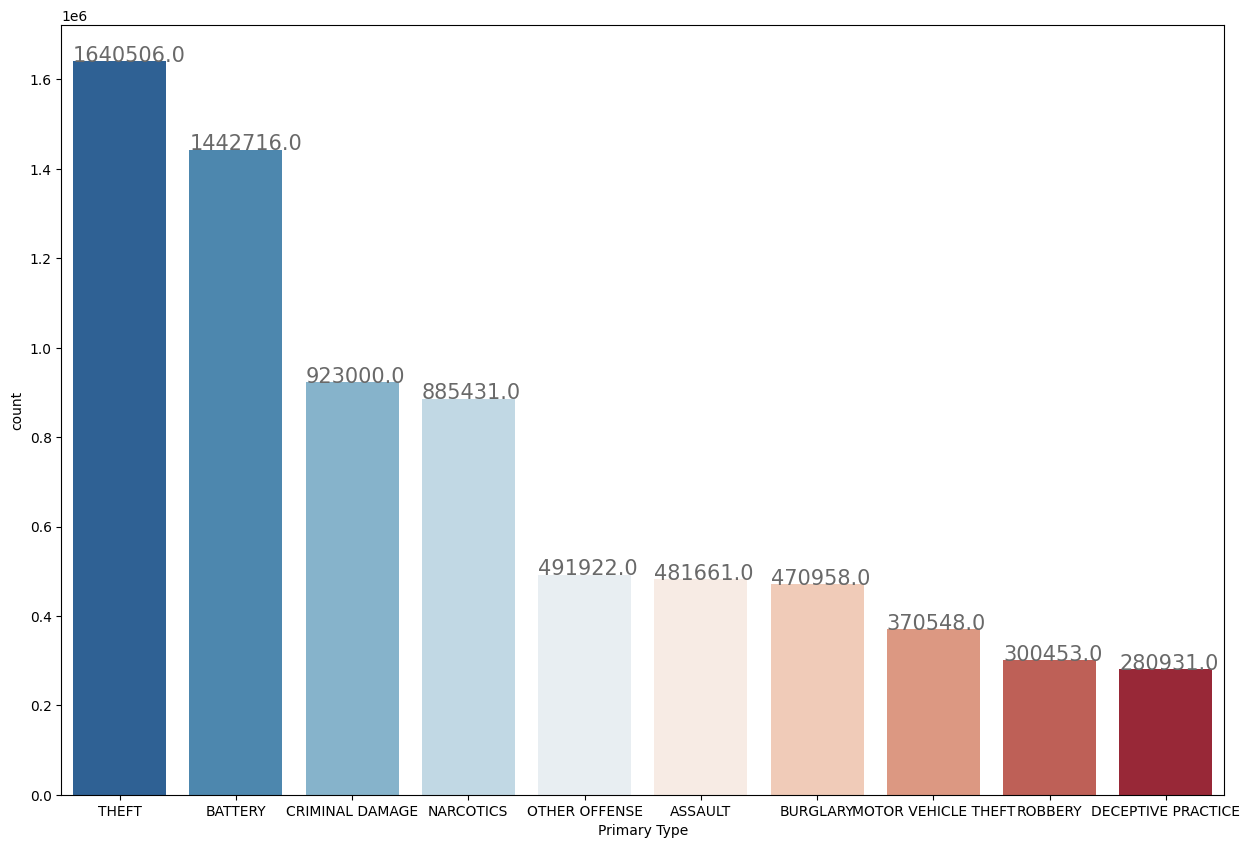

In [ ]:
# set figure size
plt.figure(figsize = (15, 10))

# plot the records
ax=sns.countplot(x= 'Primary Type', data = df, order = df['Primary Type'].value_counts().iloc[:10].index, palette = 'RdBu_r')

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(),
            str(i.get_height()), fontsize=15,color='dimgrey')
plt.show()

## Plot the top 10 Location descriptions

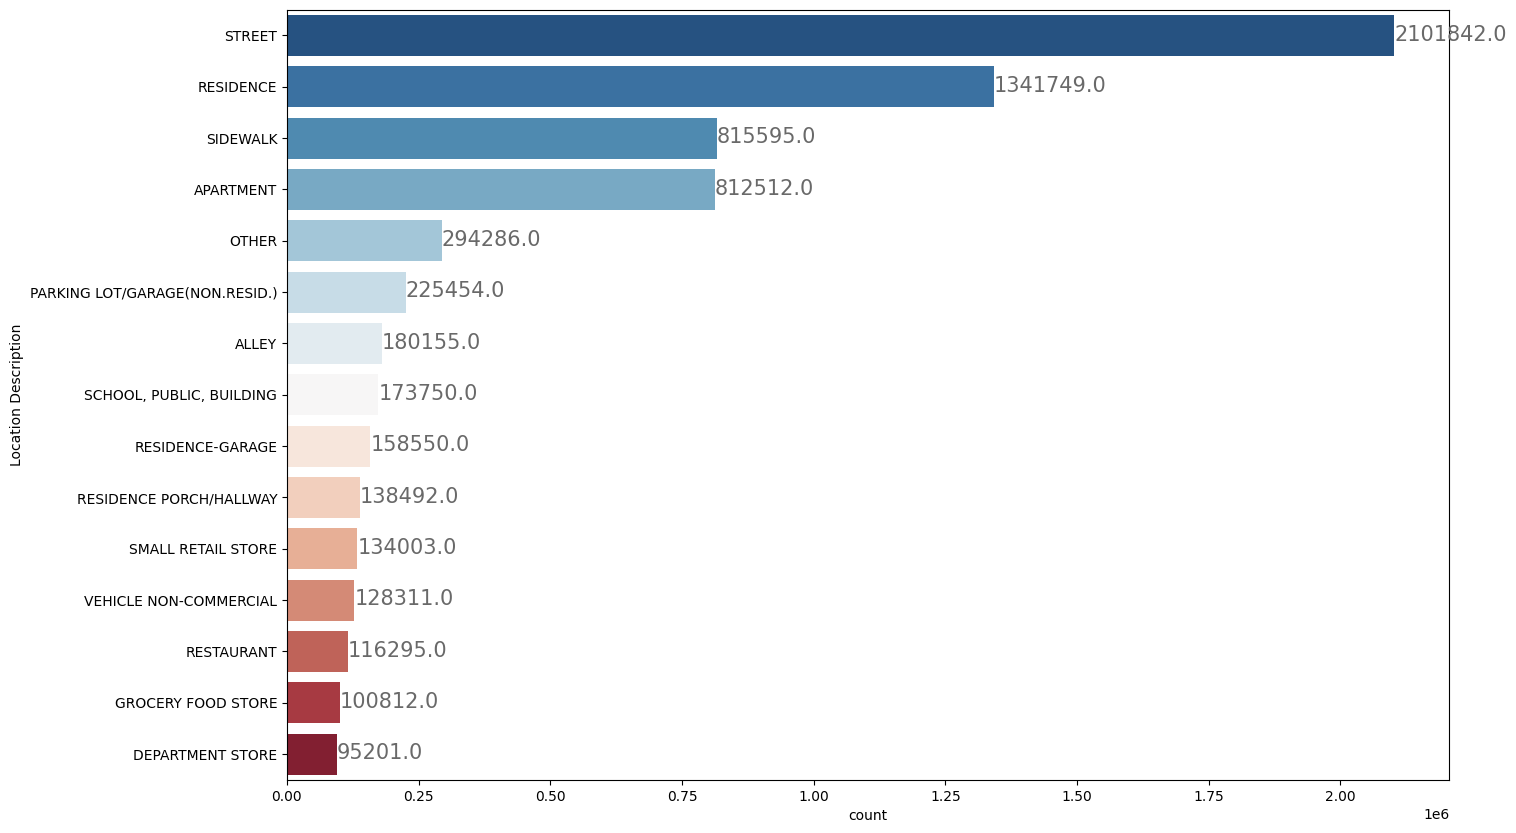

In [ ]:
# set the figure size
plt.figure(figsize = (15, 10))

# plot the values
ax = sns.countplot(y= 'Location Description', data = df, order = df['Location Description'].value_counts().iloc[:15].index,palette = 'RdBu_r')

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.5,
            str(i.get_width()), fontsize=15,color='dimgrey')
plt.show()

## resample into years

Text(0, 0.5, 'Number of Crimes')

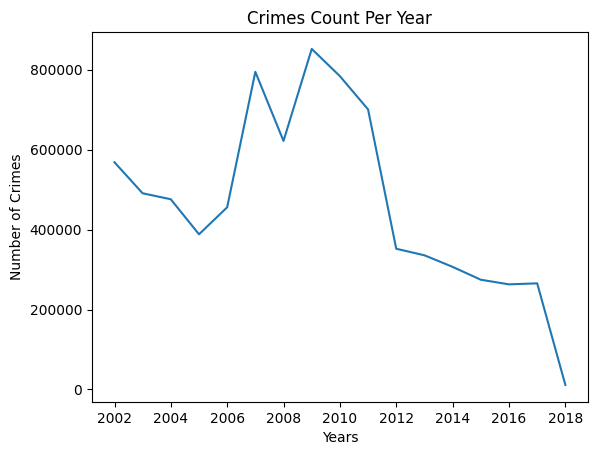

In [ ]:
plt.plot(df.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

## resample into months

Text(0, 0.5, 'Number of Crimes')

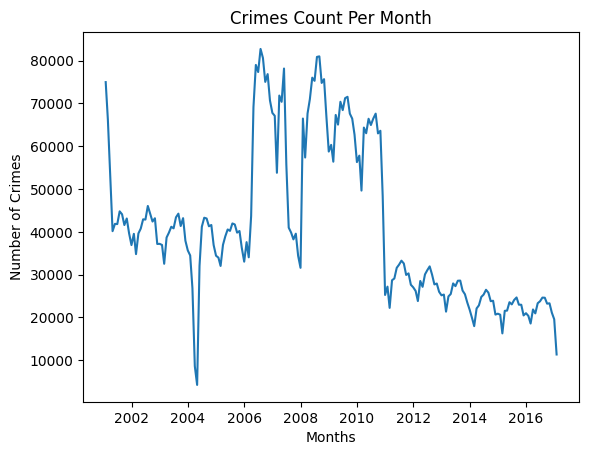

In [ ]:
plt.plot(df.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')

# Visualizing a time series


In [ ]:
# aggregating the number of cases per month for all years
c = pd.DataFrame(df.resample('M').size().reset_index())
c.columns = ['Date', 'Count'] # renaming the columns

In [ ]:
c.head()

,Date,Count
0,2001-01-31,74995
1,2001-02-28,66288
2,2001-03-31,53122
3,2001-04-30,40166
4,2001-05-31,41876


## distribution of crimes by time

In [ ]:
# plot interactive slider chart
fig = px.line(c, x='Date',y='Count', title= 'Crime count')

fig.update_xaxes(
rangeslider_visible =True,
rangeselector=dict(
        buttons=list([
                dict(count=1,label="1y",step="year",stepmode="backward"),
                dict(count=2,label="3y",step="year",stepmode="backward"),
                dict(count=3,label="5y",step="year",stepmode="backward"),
                dict(step="all")
                    ])
                )
                )
fig.show()

# Decompose Time-Series to See Components

>



In [ ]:
# Perform time series decomposition
result_add = sm.tsa.seasonal_decompose(c['Count'], model='additive', period=2)

# Access the decomposition components
trend = result_add.trend
seasonal = result_add.seasonal
residual = result_add.resid

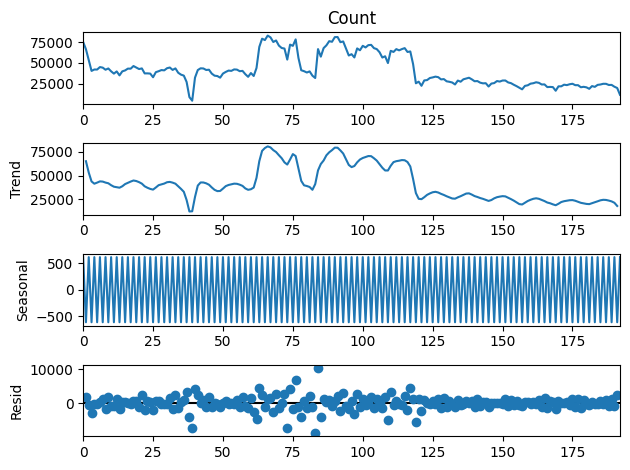

In [ ]:
result_add.plot();


In [ ]:
# Extract the Components ----
# Actual Values = Product of (Seasonal + Trend + Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
0,615.453344,NaN,NaN,74995.0
1,-615.453344,65173.25,1730.203344,66288.0
2,615.453344,53174.50,-667.953344,53122.0
3,-615.453344,43832.50,-3051.046656,40166.0
4,615.453344,41435.25,-174.703344,41876.0


# exponential smoothing

In [ ]:
optimal_alpha = None
best_mse = None
#print(c.info())
db = c.iloc[:, 1].values.astype('float32')
db = np.array([[e] for e in db])
mean_results_for_all_possible_alpha_values = np.zeros(9)
for alpha in range(0, 9):
    pt = np.mean(db[:, 0][0:5])
    mean_for_alpha = np.zeros(len(db))
    mean_for_alpha[0] = np.power(db[0][0] - pt, 2)
    for i in range(1, len(db)):
        pt = pt + ((alpha + 1) * 0.1) * (db[i - 1][0] - pt)
        mean_for_alpha[i] = np.power(db[i][0] - pt, 2)
    mean_results_for_all_possible_alpha_values[alpha] = np.mean(mean_for_alpha)
optimal_alpha = (np.argmin(mean_results_for_all_possible_alpha_values) + 1) * 0.1
best_mse = np.min(mean_results_for_all_possible_alpha_values)
print("Best MSE = %s" % best_mse)
print("Optimal alpha = %s" % optimal_alpha)

Best MSE = 43075717.40196894
Optimal alpha = 0.9


In [ ]:
pt = np.mean(db[:, 0][0:5])
for i in range(1, len(db) + 1):
    pt = pt + optimal_alpha * (db[i - 1][0] - pt)
print("Next observation = %s" % pt)

Next observation = 12197.079874600564


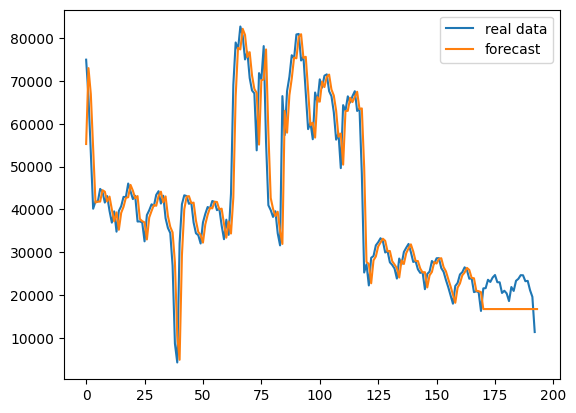

In [ ]:
forecast = np.zeros(len(db) + 1)
pt = np.mean(db[:170, 0][0:5])
forecast[0] = pt
for i in range(1, len(db[:170, 0]) + 1):
    pt = pt + 0.9 * (db[i - 1][0] - pt)
    forecast[i] = pt
for i in range(len(db[:170, 0]) + 1, len(db) + 1):
    forecast[i] = pt
plt.plot(db[:, 0],label = 'real data')
plt.plot(forecast, label = 'forecast')
plt.legend()
plt.show()

In [ ]:
# Calculate the absolute percentage error (APE)
ape = np.abs((db[170:, 0] - forecast[170:len(forecast) - 1]) / db[170:, 0]) * 100
# Calculate the mean of the APE to get the MAPE
mape = np.mean(ape)
# Print the MAPE
print('MAPE:', mape)

MAPE: 25.671275111725635


# stationarity

## ADF test to find (d)

In [ ]:
result = adfuller(c.Count.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.992456
p-value: 0.756006


In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(c.Count.diff(1).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.455548
p-value: 0.000236


# PACF and ACF

## PACF to find the AR term (p)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



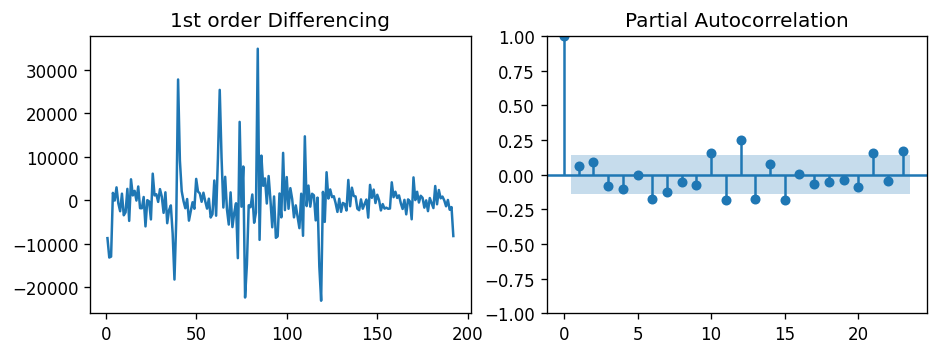

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(c.Count.diff(1)); axes[0].set_title('1st order Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(c.Count.diff(1).dropna(), ax=axes[1])

plt.show()

## ACF to find the MA term (q)

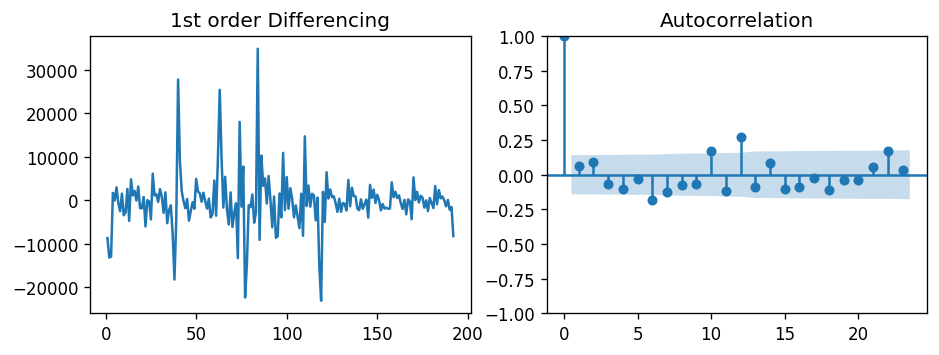

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(c.Count.diff(1)); axes[0].set_title('1st order Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(c.Count.diff(1).dropna(), ax=axes[1])

plt.show()

# ARIMA MODEL

## fitting

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(c.Count, order=(12,1,12))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  193
Model:               ARIMA(12, 1, 12)   Log Likelihood               -1932.535
Date:                Sat, 17 Jun 2023   AIC                           3915.069
Time:                        08:33:28   BIC                           3996.506
Sample:                             0   HQIC                          3948.052
                                - 193                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3386      0.533     -0.635      0.525      -1.383       0.706
ar.L2          0.4201      0.390      1.078      0.281      -0.344       1.184
ar.L3         -0.0568      0.618     -0.092      0.9

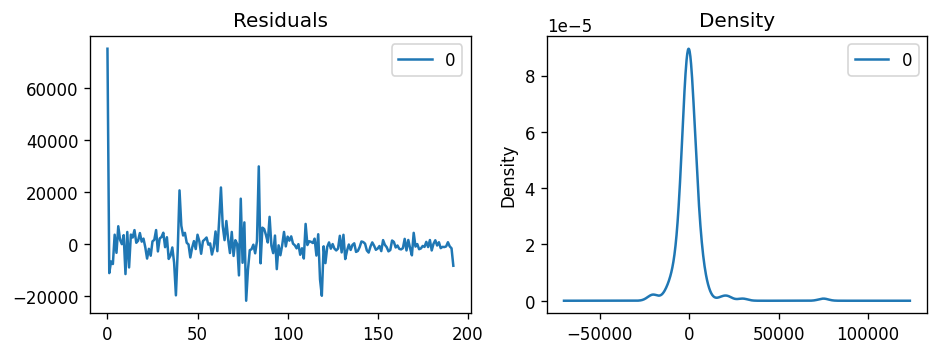

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Plotting ARIMA model


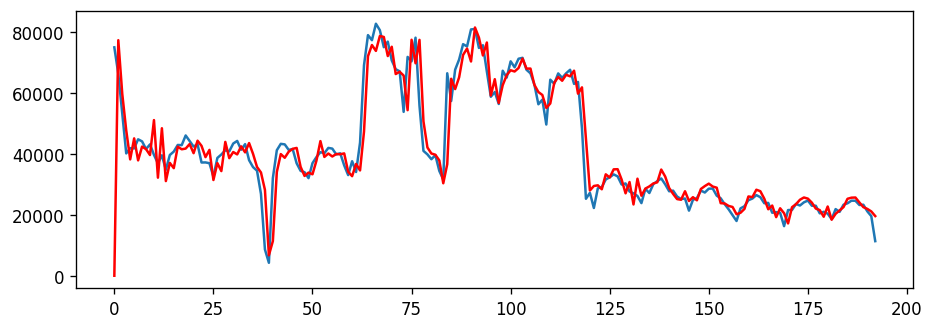

In [ ]:
# AR+I+MA = ARIMA model
model = ARIMA(c.Count, order=(12,1,12))
results_ARIMA = model.fit()
plt.plot(c.Count)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')

## training

In [ ]:
# Create Training and Test
train = c.Count[:170]
test = c.Count[170:]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



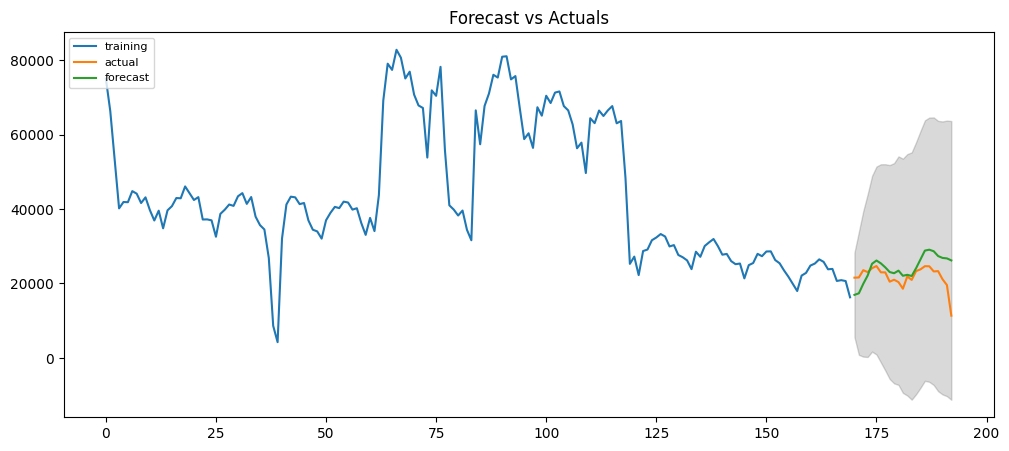

In [ ]:
# Build Model
model = ARIMA(train, order=(12,1,12))
fitted = model.fit()

# Forecast
#fc, se, conf, *_ = fitted.forecast(15, alpha=0.05)
x = fitted.get_forecast(25, alpha=0.05)
fc = x.predicted_mean  # Extract the predicted values
se = x.se_mean  # Extract the standard errors
conf = x.conf_int()  # Extract the confidence intervals

print(x)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Calculate the absolute percentage error (APE)
ape = np.abs((c.Count[170:] - x.predicted_mean) / c.Count[170:]) * 100
# Calculate the mean of the APE to get the MAPE
mape = np.mean(ape)
# Print the MAPE
print('MAPE:', mape)

MAPE: 18.88955343734659


# mapping

In [ ]:

# Get the unique community areas from the 'Community Area' column
community_areas = df['Community Area'].unique()

# Create mini datasets for each community area
mini_datasets = {}
for area in community_areas:
    mini_datasets[area] = df[df['Community Area'] == area]

# Access each mini dataset by the community area
for area, mini_dataset in mini_datasets.items():
    print(f"Community Area: {area}")
    print(mini_dataset.info())
    print("---------------------------")

Community Area: 46.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137342 entries, 2004-01-01 00:01:00 to 2016-05-03 21:07:00
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    137342 non-null  int64         
 1   Date                  137342 non-null  datetime64[ns]
 2   Primary Type          137342 non-null  object        
 3   Community Area        137342 non-null  object        
 4   Location              137342 non-null  object        
 5   Location Description  137342 non-null  object        
 6   Arrest                137342 non-null  bool          
 7   Domestic              137342 non-null  bool          
dtypes: bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 7.6+ MB
None
---------------------------
Community Area: 61.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153297 entries, 2003-03-01 00:00:00 to 2016-05-03 21:45:00
D

## community area 20

In [ ]:
mini_datasets[community_areas[19]].head()

,ID,Date,Primary Type,Community Area,Location,Location Description,Arrest,Domestic
Date,,,,,,,,
2003-01-01 00:00:00,4696401,2003-01-01 00:00:00,THEFT,10.0,"(41.975821967, -87.807053208)",COMMERCIAL / BUSINESS OFFICE,True,False
2004-06-25 18:00:00,5101703,2004-06-25 18:00:00,DECEPTIVE PRACTICE,10.0,Missing,COMMERCIAL / BUSINESS OFFICE,False,False
2001-07-15 09:00:00,5143448,2001-07-15 09:00:00,DECEPTIVE PRACTICE,10.0,"(41.98967395, -87.791552412)",RESIDENCE,False,False
2004-01-29 00:00:00,5281621,2004-01-29 00:00:00,SEX OFFENSE,10.0,Missing,APARTMENT,True,True
2003-01-29 00:00:00,5281646,2003-01-29 00:00:00,CRIM SEXUAL ASSAULT,10.0,Missing,APARTMENT,True,False


In [ ]:
# get the summary
print ("Rows     : " ,mini_datasets[community_areas[19]].shape[0])
print ("Columns  : " ,mini_datasets[community_areas[19]].shape[1])
print ("\nFeatures : \n\n" ,df.columns.tolist())
print ("\nMissing values : \n\n", mini_datasets[community_areas[19]].isnull().any())
print ("\nUnique values :  \n\n",mini_datasets[community_areas[19]].nunique())

Rows     :  30791
Columns  :  8

Features : 

 ['ID', 'Date', 'Primary Type', 'Community Area', 'Location', 'Location Description', 'Arrest', 'Domestic']

Missing values : 

 ID                      False
Date                    False
Primary Type            False
Community Area          False
Location                False
Location Description    False
Arrest                  False
Domestic                False
dtype: bool

Unique values :  

 ID                      23669
Date                    22704
Primary Type               28
Community Area              1
Location                 7461
Location Description       84
Arrest                      2
Domestic                    2
dtype: int64


In [ ]:
# aggregating the number of cases per month for all years
CA = pd.DataFrame(mini_datasets[community_areas[19]].resample('M').size().reset_index())
CA.columns = ['Date', 'Count'] # renaming the columns

In [ ]:
CA.head(10)

,Date,Count
0,2001-01-31,1
1,2001-02-28,0
2,2001-03-31,1
3,2001-04-30,0
4,2001-05-31,1
5,2001-06-30,1
6,2001-07-31,2
7,2001-08-31,1
8,2001-09-30,0
9,2001-10-31,2


In [ ]:
# plot interactive slider chart
fig = px.line(CA, x='Date',y='Count', title= 'Crime count')

fig.update_xaxes(
rangeslider_visible =True,
rangeselector=dict(
        buttons=list([
                dict(count=1,label="1y",step="year",stepmode="backward"),
                dict(count=2,label="3y",step="year",stepmode="backward"),
                dict(count=3,label="5y",step="year",stepmode="backward"),
                dict(step="all")
                    ])
                )
                )
fig.show()

In [ ]:
# Perform time series decomposition
result_add = sm.tsa.seasonal_decompose(CA['Count'], model='additive', period=2)

# Access the decomposition components
trend = result_add.trend
seasonal = result_add.seasonal
residual = result_add.resid

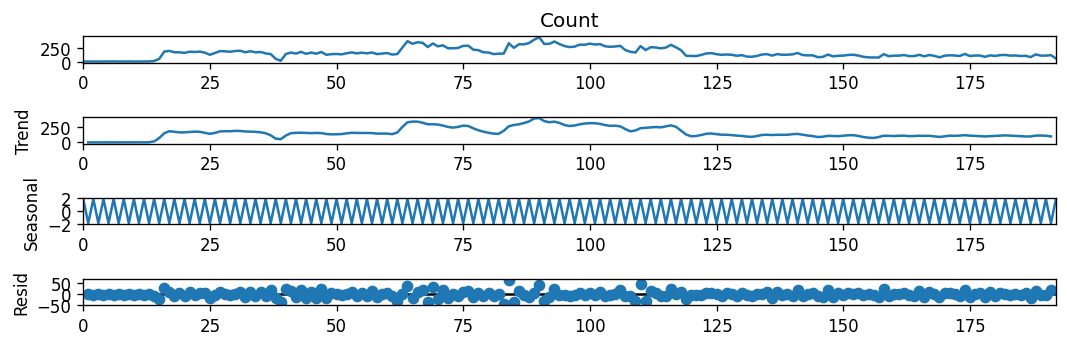

In [ ]:
result_add.plot();

In [ ]:
# Extract the Components ----
# Actual Values = Product of (Seasonal + Trend + Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
0,1.855181,NaN,NaN,1.0
1,-1.855181,0.50,1.355181,0.0
2,1.855181,0.50,-1.355181,1.0
3,-1.855181,0.50,1.355181,0.0
4,1.855181,0.75,-1.605181,1.0


In [ ]:
result = adfuller(CA.Count.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('used lag: %f' % result[2] )

ADF Statistic: -3.100640
p-value: 0.026506
used lag: 0.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



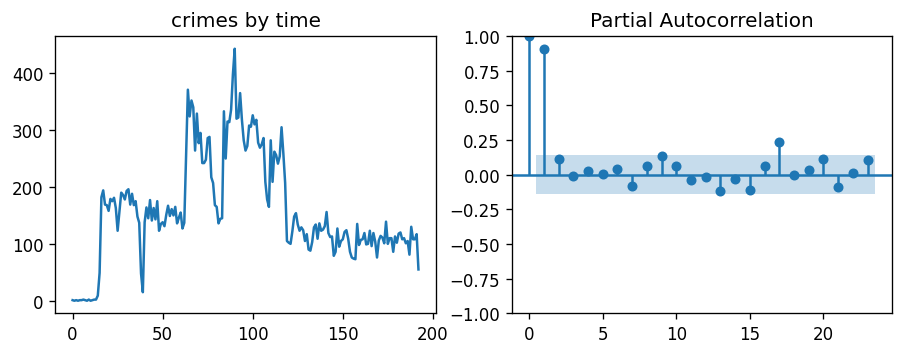

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(CA.Count); axes[0].set_title('crimes by time')
axes[1].set(ylim=(0,5))
plot_pacf(CA.Count.dropna(), ax=axes[1])

plt.show()

In [ ]:
model = pm.auto_arima(CA.Count, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)


print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1942.181, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1946.263, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1943.995, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1943.719, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1944.274, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1943.547, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1943.627, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1945.511, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1945.827, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1940.268, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1941.740, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1942.014, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1941.627, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [ ]:
# Create Training and Test
train = CA.Count[:170]
test = CA.Count[170:]

In [ ]:
res = {}
# Iterate over each dataset in mini_datasets
for community_area in community_areas:
    # Resample the dataset to monthly frequency
    CA = pd.DataFrame(mini_datasets[community_area].resample('M').size().reset_index())
    CA.columns = ['Date', 'Count']

    # Split the dataset into train and test sets
    train_size = int(len(CA) * 0.8)  # 80% for training
    train, test = CA[:train_size], CA[train_size:]

    # Apply auto_arima to find the best ARIMA model
    model = pm.auto_arima(train['Count'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

    # Print the model summary
    print(f"Community Area: {community_area}")
    print(model.summary())
    print("-----------------------")

    # Make predictions on the test set
    predictions = model.predict(n_periods=len(test))

    # Create a DataFrame with the actual and predicted values
    results = pd.DataFrame({'Actual': test['Count'], 'Predicted': predictions}, index=test.index)
    res[community_area] = results
    results.to_csv(str(community_area), index=False)

    # Print the results
    print(results)
    print("-----------------------")

Streaming output truncated to the last 5000 lines.
176     689      797.0
177     697      797.0
178     576      797.0
179     639      797.0
180     614      797.0
181     569      797.0
182     684      797.0
183     609      797.0
184     699      797.0
185     751      797.0
186     750      797.0
187     737      797.0
188     694      797.0
189     649      797.0
190     584      797.0
191     579      797.0
192     362      797.0
-----------------------
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1532.524, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1535.359, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1535.133, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1533.852, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1533.393, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1533.274, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1532.792, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] inter

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 77.9 MB/s eta 0:00:00


In [ ]:
# Specify the row index (i-th row)
row_index = 1

# Create an empty DataFrame to store the result
result_df = pd.DataFrame()

# Iterate over the dictionary values
for df_name, df in res.items():
    # Extract the i-th row from each DataFrame
    row = df.iloc[row_index]

    # Add the row as a new row to the result DataFrame
    result_df = pd.concat([result_df, row.to_frame().T], ignore_index=True)

# Print the resulting DataFrame
print(result_df)

    Actual    Predicted
0    389.0   529.000000
1    406.0   528.000000
2    450.0   476.000000
3    157.0   143.912577
4    554.0   707.518522
..     ...          ...
74    37.0    44.022219
75    14.0    28.367320
76    32.0 -1186.467742
77   116.0   130.857535
78     1.0     0.317595

[79 rows x 2 columns]


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd

<Axes: >

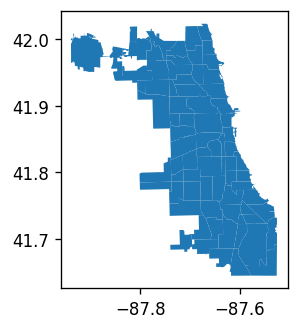

In [ ]:
#read in once
df_places = gpd.read_file('/content/drive/MyDrive/chicago_map.geojson')
df_places.plot()

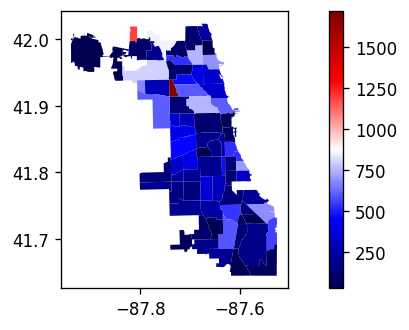

In [ ]:
df = result_df

# Assuming you have a DataFrame named 'df' with a 'predicted' column
# Merge the 'predicted' column from df into the GeoDataFrame
df_merged = df_places.merge(df[['Predicted']], left_index=True, right_index=True)

# Plot the GeoDataFrame and color the areas based on the 'predicted' column
df_merged.plot(column='Predicted', cmap='seismic', legend=True)

# Display the plot
plt.show()